# rACS Toy Environment

In [1]:
# Logger
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools

# Import local paths
import sys, os
sys.path.append(os.path.abspath('../../..'))
sys.path.append(os.path.abspath('../../../../openai-envs'))

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from lcs.representations.RealValueEncoder import RealValueEncoder
from lcs.agents.racs import RACS, Configuration
from lcs.metrics import population_metrics

# Load OpenAI environments
import gym
import gym_real_value_toy

## Single boundary
This environment renders two dimensional space where the first dimension is responsible for determining class value. The threshold is set to `x < 0.5`.

In [2]:
env = gym.make('orthogonal-single-boundary-v0')
env.reset()

[0.21164740585926423, 0.6317627744036273, 0]

The agent should ...

In [3]:
def build_agent(env, encoder_bits):
    cfg = Configuration(env.observation_space.shape[0], env.action_space.n,
                        encoder=RealValueEncoder(encoder_bits),
                        metrics_trial_frequency=5,
                        user_metrics_collector_fcn=population_metrics,
                        epsilon=1.0,  # no biased exploration
                        do_ga=False,
                        theta_r=0.9,  # reliablity threshold
                        theta_i=0.2,  # inadequacy threshold
                        theta_ga=100,
                        chi=0.5,  # cross-over probability
                        mu=0.1,  # mutation probability
                        mutation_noise=1.0)  

    return RACS(cfg)

Explore the environment

In [4]:
%%time

agent = build_agent(env, 2)
population, metrics = agent.explore_exploit(env, 5_000)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1, 'reward': 0, 'population': 1, 'numerosity': 1, 'reliable': 0}


CPU times: user 3.37 s, sys: 43.1 ms, total: 3.41 s
Wall time: 3.6 s


Divide explored population by niches

In [5]:
population = [cl for cl in population if cl.is_reliable()]
population = sorted(population, key=lambda cl: cl.action)

for action, classifiers in itertools.groupby(population, key=lambda cl: cl.action):
    classifiers = list(classifiers)
    print(f"\n=== Action [{action}] ({len(classifiers)}) ===")
    for cl in classifiers:
        print(f"\n{cl.condition}\t{cl.condition._items}")
        print(f"{cl.effect}\t{cl.effect._items}")
        print(f"q: {cl.q:.2f}, fit: {cl.fitness:.2f}, num: {cl.num}")


=== Action [0] (10) ===

O...|OOOO|OOOO	[UBR(x1=0, x2=0), UBR(x1=0, x2=3), UBR(x1=0, x2=3)]
OOOO|OOOO|OOOO	[UBR(x1=0, x2=3), UBR(x1=0, x2=3), UBR(x1=0, x2=3)]
q: 1.00, fit: 0.00, num: 1

.O..|OOOO|OOOO	[UBR(x1=1, x2=1), UBR(x1=0, x2=3), UBR(x1=0, x2=3)]
OOOO|OOOO|OOOO	[UBR(x1=0, x2=3), UBR(x1=0, x2=3), UBR(x1=0, x2=3)]
q: 1.00, fit: 0.00, num: 1

..O.|OOOO|O...	[UBR(x1=2, x2=2), UBR(x1=0, x2=3), UBR(x1=0, x2=0)]
OOOO|OOOO|...O	[UBR(x1=0, x2=3), UBR(x1=0, x2=3), UBR(x1=3, x2=3)]
q: 1.00, fit: 1.00, num: 1

...O|OOOO|O...	[UBR(x1=3, x2=3), UBR(x1=0, x2=3), UBR(x1=0, x2=0)]
OOOO|OOOO|...O	[UBR(x1=0, x2=3), UBR(x1=0, x2=3), UBR(x1=3, x2=3)]
q: 1.00, fit: 1.00, num: 1

..O.|..O.|O...	[UBR(x1=2, x2=2), UBR(x1=2, x2=2), UBR(x1=0, x2=0)]
OOOO|OOOO|...O	[UBR(x1=0, x2=3), UBR(x1=0, x2=3), UBR(x1=3, x2=3)]
q: 1.00, fit: 1.00, num: 1

...O|..O.|O...	[UBR(x1=3, x2=3), UBR(x1=2, x2=2), UBR(x1=0, x2=0)]
OOOO|OOOO|...O	[UBR(x1=0, x2=3), UBR(x1=0, x2=3), UBR(x1=3, x2=3)]
q: 1.00, fit: 1.00, num: 1

..

Let's validate if we have any duplicate classifiers inside population

In [6]:
import itertools

combinations = list(itertools.product(population, population))  # cartesian product

similar = sum(1 for (cl1, cl2) in combinations if cl1 == cl2)  # all similar pairs
diagonal = len(population)  # classifiers on diagonal (identities)

similar - diagonal

0

Visualize learning progress

In [7]:
def parse_metrics(metrics):
    lst = [[
        d['trial'],
        d['population'],
        d['numerosity'],
        d['reliable'],
        d['reward']
    ] for d in metrics]

    df = pd.DataFrame(lst, columns=['trial', 'population', 'numerosity', 'reliable', 'reward'])
    df = df.set_index('trial')

    return df

df = parse_metrics(metrics)
df['mode'] = df.index.map(lambda t: "explore" if t % 2 == 0 else "exploit")
df.head()

,population,numerosity,reliable,reward,mode
trial,,,,,
0,1,1,0,0,explore
5,3,3,0,0,exploit
10,3,3,0,0,explore
15,5,5,0,0,exploit
20,8,8,0,0,explore


In [8]:
explore_df = df[df['mode'] == 'explore']
exploit_df = df[df['mode'] == 'exploit']

## Performance plot

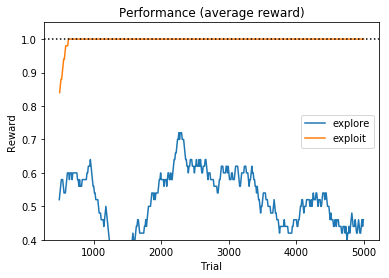

In [9]:
window = 50

fig, ax = plt.subplots()
explore_df['reward'].rolling(window=window).mean().plot(label='explore', ax=ax)
exploit_df['reward'].rolling(window=window).mean().plot(label='exploit', ax=ax)
plt.axhline(1.0, c='black', linestyle=':')

ax.set_title('Performance (average reward)')
ax.set_xlabel('Trial')
ax.set_ylabel('Reward')
ax.set_ylim([.4, 1.05])

plt.legend()
plt.show()

### Classifiers plot

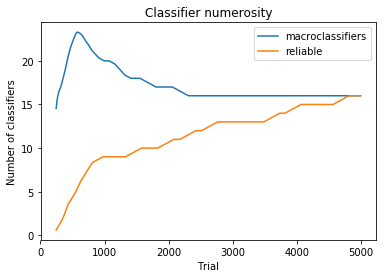

In [10]:
window=50

fig, ax = plt.subplots()
df['population'].rolling(window=window).mean().plot(label='macroclassifiers', ax=ax)
df['reliable'].rolling(window=window).mean().plot(label='reliable', ax=ax)

ax.set_title('Classifier numerosity')
ax.set_xlabel('Trial')
ax.set_ylabel('Number of classifiers')

plt.legend()
plt.show()